# Lab 7 : Clustering - Part 2

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.neighbors import KernelDensity

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import OPTICS

from sklearn.metrics.pairwise import euclidean_distances

import warnings
warnings.filterwarnings('ignore')

We consider the 2 following datasets (X1 and X2) that will be used in all of this lab's exercises :

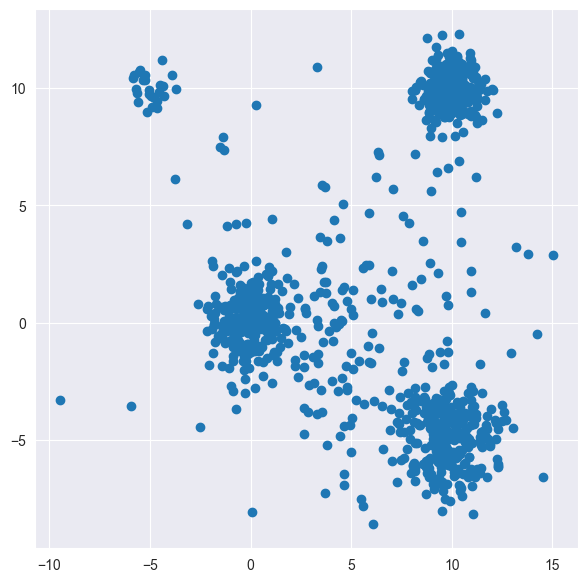

In [27]:
np.random.seed(33)  #for reproductibility
a=np.random.multivariate_normal( [5, 0], [[0, 15], [15, 0]], 200)
b=np.random.multivariate_normal( [0, 0], [[0, 1], [1, 0]], 250)
c=np.random.multivariate_normal( [10, -5], [[0, 1.5], [1.5, 0]], 250)
d=np.random.multivariate_normal( [10, 10], [[0, 0.5], [0.5, 0]], 350)
e=np.random.multivariate_normal( [-5, 10], [[0, 0.4], [0.4, 0]], 25)
X1 = np.concatenate((a, b, c, d, e),)

# Generate scatter plot
plt.figure(figsize=(7, 7))
plt.scatter(X1[:,0],X1[:,1])

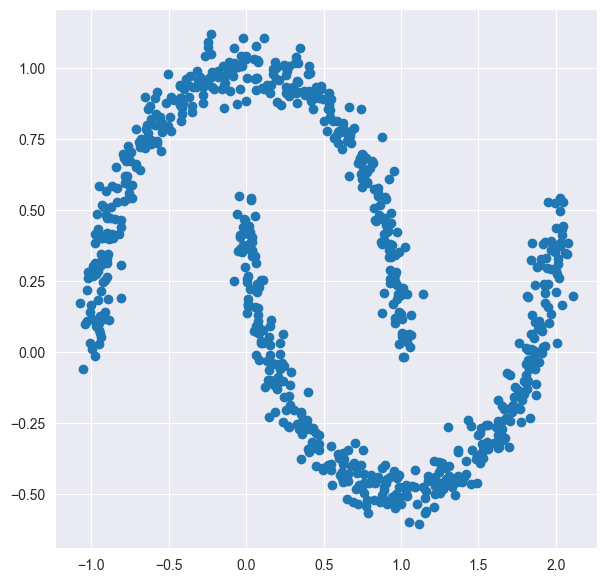

In [28]:
X2, y = make_moons(n_samples=750, shuffle=True, noise=0.05, random_state=33)
# Generate scatter plot
plt.figure(figsize=(7, 7))
plt.scatter(X2[:,0],X2[:,1])

## Part A : K-Means vs Meanshift

#### Question 1 : Run the K-Means algorithm on the two datasets (you may want to search for the optimal number of clusters with X1). Then comment on your results : In particular, you will explain why the K-Means algorithm may not be suited for these 2 datasets.

In [29]:
## first dataset : searching for the optimal number of clusters

history_DB=[]
history_CH=[]
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(X1)
    labels = kmeans.labels_
    value_DB = davies_bouldin_score(X1, labels)
    value_CH = calinski_harabasz_score(X1, labels)
    history_DB.append(value_DB)
    history_CH.append(value_CH)
x_value = np.arange(2,11)

Delta_DB=np.gradient(history_DB)
print(Delta_DB)

Delta_CH=np.gradient(history_CH)
print(Delta_CH)

[-0.22243564  0.05401723  0.08264331 -0.02889915  0.03885388  0.05327144
  0.05702787  0.03696227  0.09608912]
[2079.32171668  742.54585788  214.17686875  388.04346395 -178.30047923
 -172.92154032 -228.94639907 -125.38084168  -28.60781793]


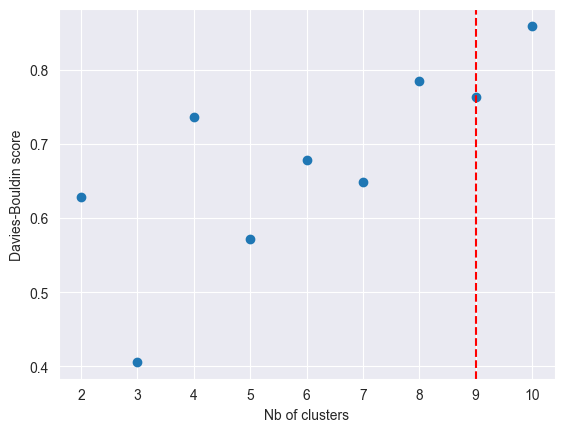

In [30]:
#elbow method
fig, ax = plt.subplots()
ax.scatter(range(2, 11), history_DB)
ax.axvline(x=2+np.argmax(Delta_DB)-1, color="red", linestyle="--", label='the best partition')
ax.set_xlabel("Nb of clusters")
ax.set_ylabel("Davies-Bouldin score")
plt.show()

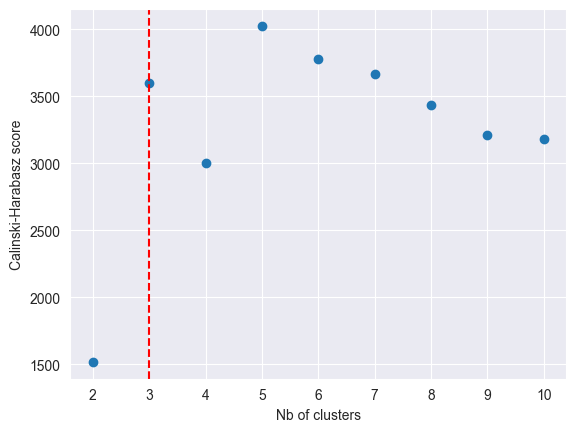

In [31]:
#elbow method
fig, ax = plt.subplots()
ax.scatter(range(2, 11), history_CH)
ax.axvline(x=2+np.argmax(Delta_CH)+1, color="red", linestyle="--", label='the best partition')
ax.set_xlabel("Nb of clusters")
ax.set_ylabel("Calinski-Harabasz score")
plt.show()

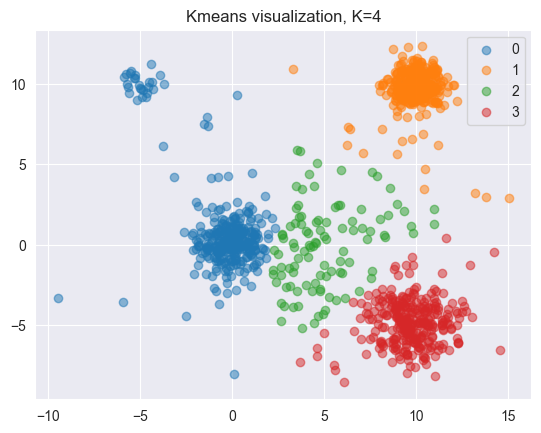

In [32]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(X1)
cluster_x1_means=kmeans.labels_

fig, ax = plt.subplots()
for i, cl in enumerate(np.unique(cluster_x1_means)): 
    ax.scatter(X1[:,0][cluster_x1_means==cl], X1[:,1][cluster_x1_means==cl], label=cl, alpha=0.5) 
ax.legend()
plt.title('Kmeans visualization, K=4')
plt.show()

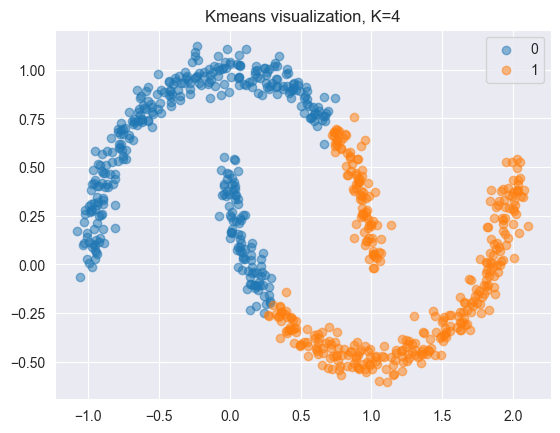

In [33]:
##Kmeans, 2nd dataset (k=2)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, max_iter=100).fit(X2)
cluster_x2_means=kmeans.labels_

colors = "bgrcmykw"
fig, ax = plt.subplots()
for i, cl in enumerate(np.unique(cluster_x2_means)): 
    ax.scatter(X2[:,0][cluster_x2_means==cl], X2[:,1][cluster_x2_means==cl], label=cl, alpha=0.5) 
ax.legend()
plt.title('Kmeans visualization, K=4')
plt.show()

<u>Answer 1 :</u>

The K-Means algorithm can only capture spherical or almost spherical
clusters. Any non-convex shape will be missed.
Clusters with different density or sizes can also be difficult to find
using the K-Means algorithm.
For datasets X1 and X2 it does not work that well because of unequal density and not that well formed shape in X1 and non-spherical shape of X2.

#### Question 2 : Using the KernelDensity function from sklearn, visualize the estimate densities of probability for both your datasets. If you use code from the internet, please mention your sources. You may try different value for the bandwidth parameter of your Gaussian kernel. Comment on the results.

In [34]:
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations
    xmin=np.min(x)-1
    xmax=np.max(x)+1
    ymin=np.min(y)-1
    ymax=np.max(y)+1    
    xx, yy = np.mgrid[xmin:xmax:xbins, ymin:ymax:ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

def Display(D,h):
    X=D[:,0]
    Y=D[:,1]
    xx, yy, zz = kde2D(X,Y,h)
    xmin=np.min(X)-1
    xmax=np.max(X)+1
    ymin=np.min(Y)-1
    ymax=np.max(Y)+1     
    fig, ax = plt.subplots(figsize=(10,10))  
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    cfset = ax.contourf(xx, yy, zz, cmap='coolwarm')
    ax.imshow(np.rot90(zz), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
    cset = ax.contour(xx, yy, zz, colors='k')
    ax.scatter(X, Y, color='k')
    plt.show()

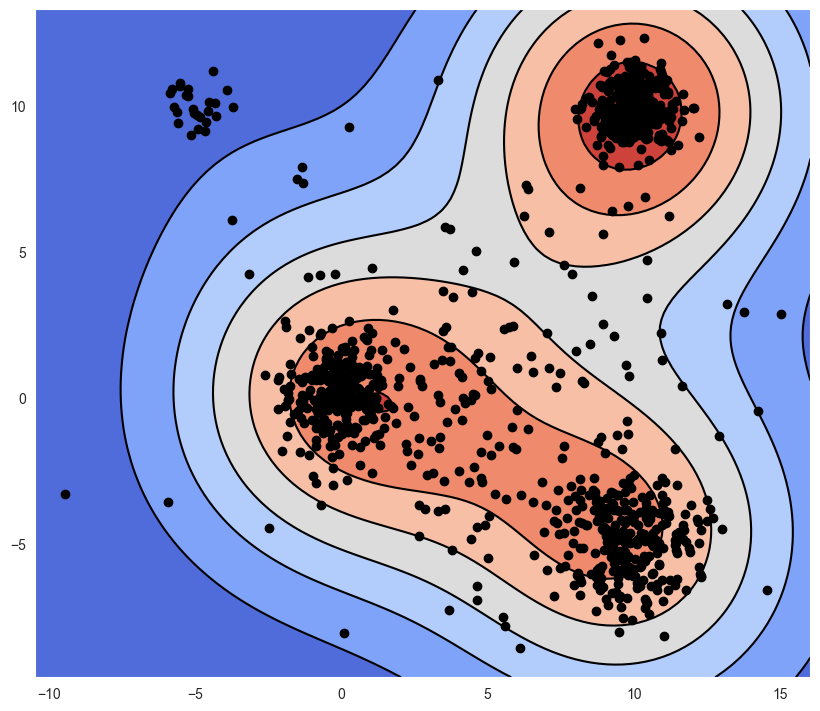

In [35]:
Display(X1,4.0)

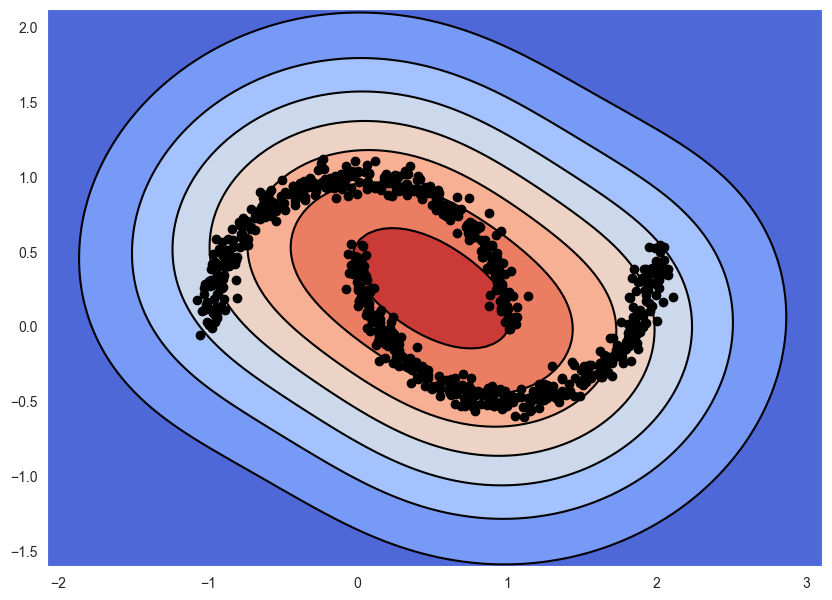

In [36]:
Display(X2,0.7)

<u>Answer 2 :</u>

With different bandwidth the results can have no sense as it can show density in circular area where each point have the similar level of density.

#### Question 3 : Apply Meanshift clustering from sklearn to both datasets. Project your results and comment. In particular, you will focus on the influence of the bandwidth parameter and its role in the quality of the results.

In [37]:
h=4.0
ms = MeanShift(bandwidth=h, bin_seeding=True).fit(X1)
ms_labels = ms.labels_
cluster_centers_x1 = ms.cluster_centers_

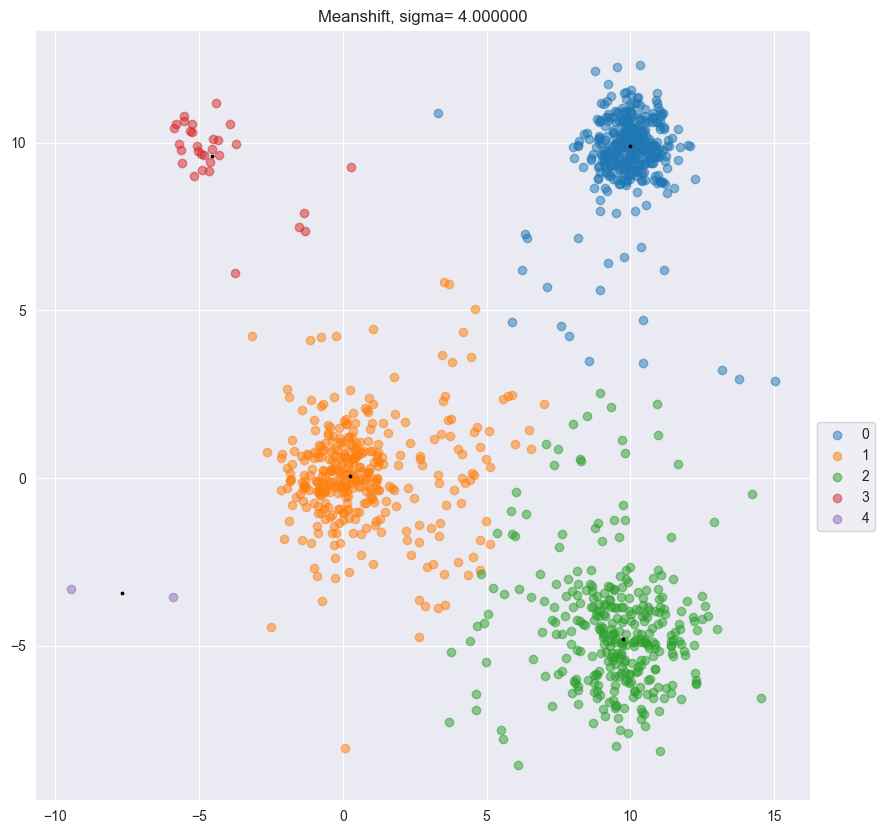

In [38]:
fig, ax = plt.subplots(figsize=(10,10))  
for i, cl in enumerate(np.unique(ms_labels)): 
    ax.scatter(X1[:,0][ms_labels==cl], X1[:,1][ms_labels==cl], label=cl, alpha=0.5) 
ax.legend(bbox_to_anchor=(1, 0.5))
ax.scatter(cluster_centers_x1[:,0],cluster_centers_x1[:,1],c='black',s=3)
plt.title("Meanshift, sigma= %f" % h)
plt.show()

In [39]:
h=0.7
ms = MeanShift(bandwidth=h, bin_seeding=True).fit(X2)
ms_labels_2 = ms.labels_
cluster_centers_x2 = ms.cluster_centers_

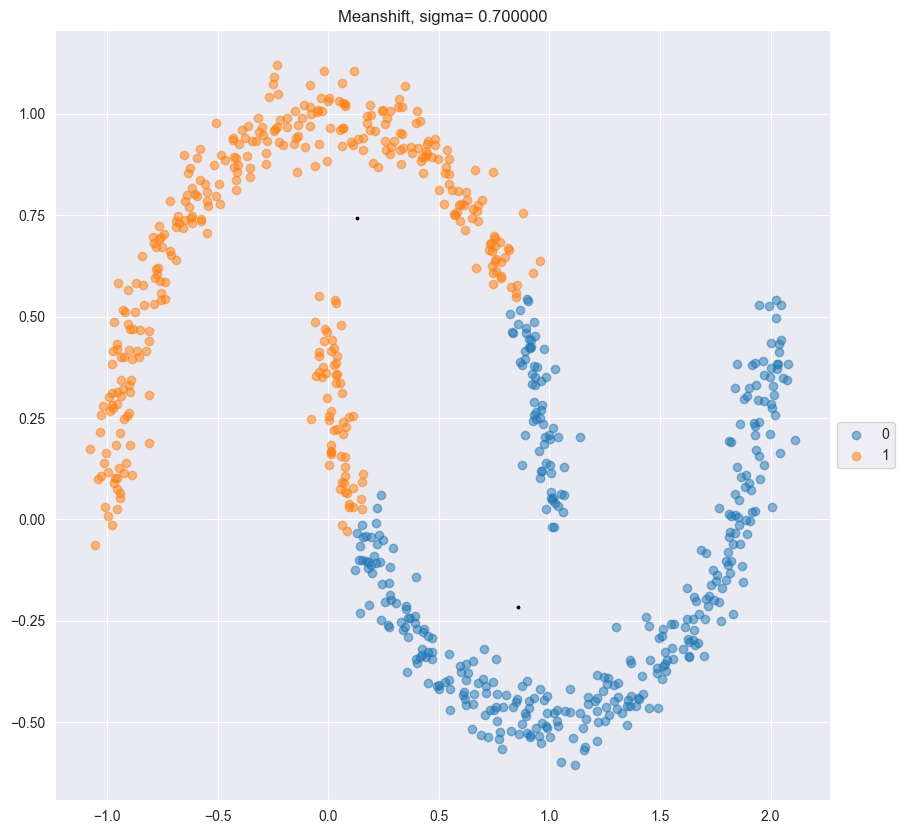

In [40]:
fig, ax = plt.subplots(figsize=(10,10))  
for i, cl in enumerate(np.unique(ms_labels_2)): 
    ax.scatter(X2[:,0][ms_labels_2==cl], X2[:,1][ms_labels_2==cl], label=cl, alpha=0.5) 
ax.legend(bbox_to_anchor=(1, 0.5))
ax.scatter(cluster_centers_x2[:,0],cluster_centers_x2[:,1],c='black',s=3)
plt.title("Meanshift, sigma= %f" % h)
plt.show()

<u>Answer 3 :</u>

MeanShift gives good results. But not for X2 dataset.

## Part B : OPTICS

#### Question 1 : Run the OPTICS algorithm from sklearn on the first data (try several parameters). Then propose a visualization that accounts for noise points. You will also display the reachability plot. Comment.

Remark : For the reachability plot, you will need the *reachability_* and *ordering_* attributes from the post-OPTICS computation object.

In [41]:
clust = OPTICS(min_samples=25, max_eps=2)
clust.fit(X1)
x1_labels = clust.labels_
no_clusters = len(np.unique(x1_labels) ) -1
no_noise = np.sum(np.array(x1_labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 4
Estimated no. of noise points: 130


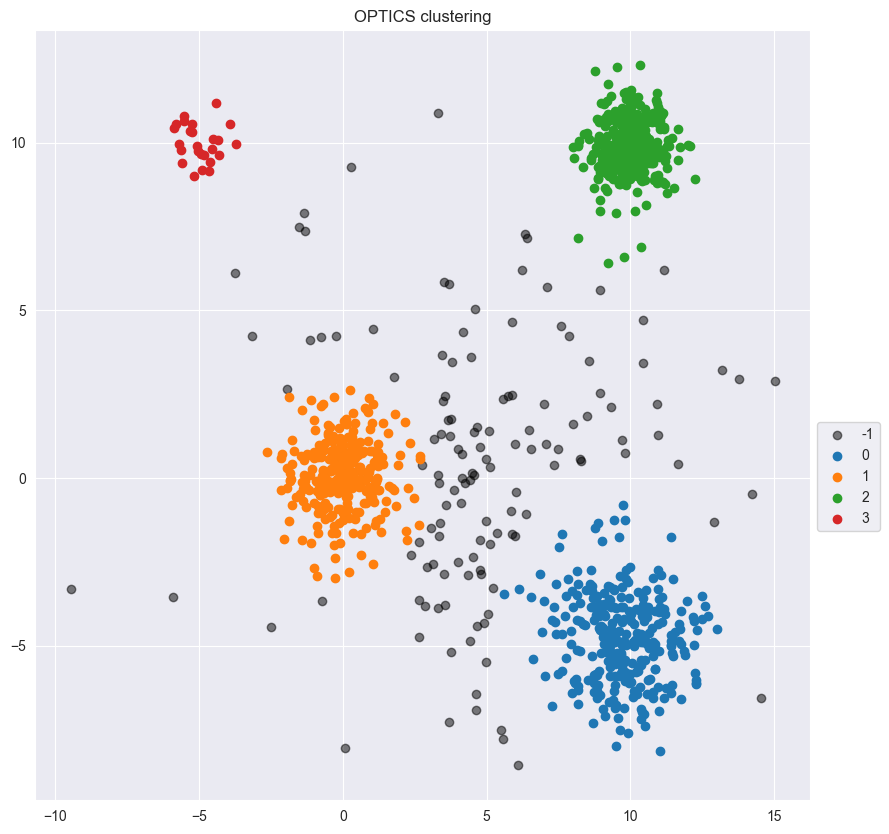

In [42]:
# Generate scatter plot
fig, ax = plt.subplots(figsize=(10,10))  
for i, cl in enumerate(np.unique(x1_labels)):
    if(cl==-1):
        ax.scatter(X1[:,0][x1_labels==cl], X1[:,1][x1_labels==cl], label=cl, alpha=0.5, color="black") 
    else:
        ax.scatter(X1[:,0][x1_labels==cl], X1[:,1][x1_labels==cl], label=cl, alpha=1) 
ax.legend(bbox_to_anchor=(1, 0.5))
plt.title('OPTICS clustering')
plt.show()

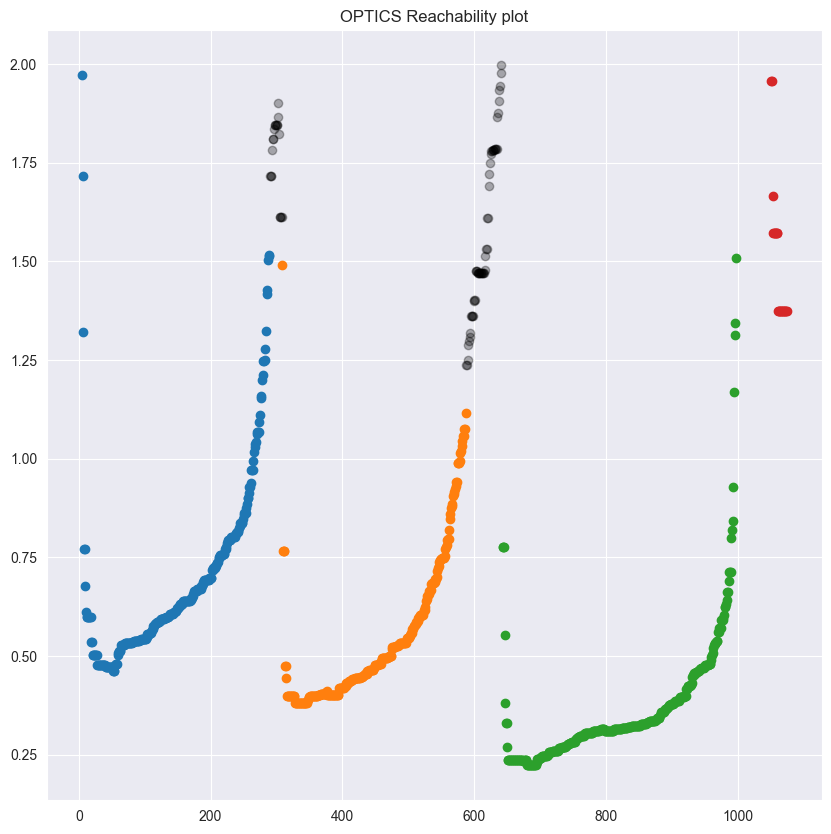

In [43]:
#reachability plot
olabels = clust.labels_[clust.ordering_]
reachability = clust.reachability_[clust.ordering_]
space = np.arange(len(X1))
fig, ax = plt.subplots(figsize=(10,10))  
for i, cl in enumerate(np.unique(olabels)):
    if(cl==-1):
        plt.scatter(space[olabels == cl], reachability[olabels==cl],label=cl, color="black", alpha=0.3)  
    else:    
        plt.scatter(space[olabels == cl], reachability[olabels==cl], label=cl, alpha=1)   
plt.title('OPTICS Reachability plot')
plt.show()

#### Question 2 : Same question for the second dataset.

In [44]:
clust = OPTICS(min_samples=35, max_eps=1)
clust.fit(X2)
x2_labels = clust.labels_
no_clusters = len(np.unique(x2_labels) ) -1
no_noise = np.sum(np.array(x2_labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 1


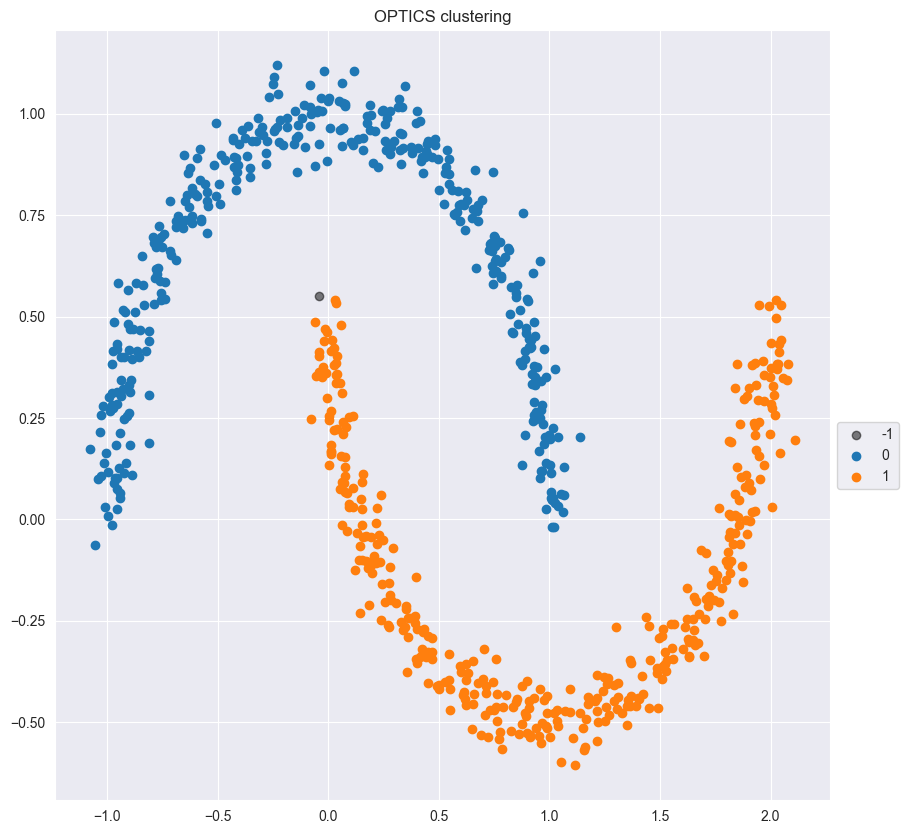

In [45]:
# Generate scatter plot
fig, ax = plt.subplots(figsize=(10,10))  
for i, cl in enumerate(np.unique(x2_labels)):
    if(cl==-1):
        ax.scatter(X2[:,0][x2_labels==cl], X2[:,1][x2_labels==cl], label=cl, alpha=0.5, color="black") 
    else:
        ax.scatter(X2[:,0][x2_labels==cl], X2[:,1][x2_labels==cl], label=cl, alpha=1) 
ax.legend(bbox_to_anchor=(1, 0.5))
plt.title('OPTICS clustering')
plt.show()

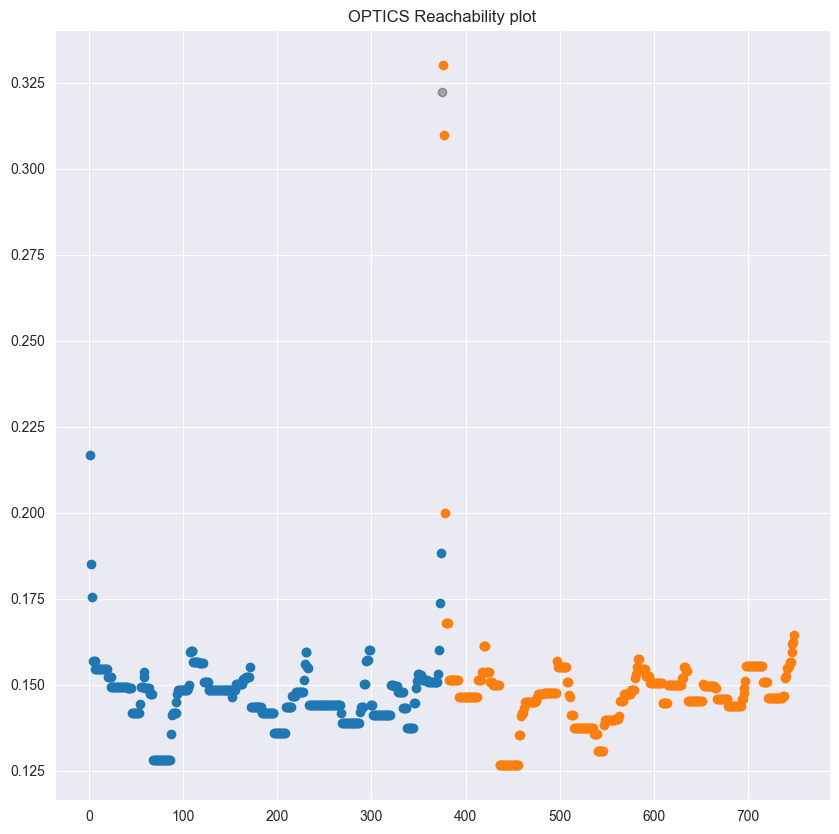

In [46]:
#reachability plot
olabels = clust.labels_[clust.ordering_]
reachability = clust.reachability_[clust.ordering_]
space = np.arange(len(X2))
fig, ax = plt.subplots(figsize=(10,10))  
for i, cl in enumerate(np.unique(olabels)):
    if(cl==-1):
        plt.scatter(space[olabels == cl], reachability[olabels==cl],label=cl, color="black", alpha=0.3)  
    else:    
        plt.scatter(space[olabels == cl], reachability[olabels==cl], label=cl, alpha=1)   
plt.title('OPTICS Reachability plot')
plt.show()

#### Question 3 : Comment on the pros and cons of using OPTICS on these datasets.

<u>Answer 3 : </u>

Pros:

Automatic cluster detection: OPTICS does not require specifying the number of clusters beforehand, unlike K-Means, which requires the user to provide the number of clusters.

Flexibility in cluster shapes: While K-Means assumes that clusters are spherical and isotropic, and Mean Shift assumes that clusters are centered around modes of the density function, OPTICS can identify clusters of arbitrary shapes and sizes. This flexibility allows OPTICS to handle datasets with complex structures more effectively.

Robustness to noise: OPTICS is robust to noise and outliers because it does not force every point to belong to a cluster. Points that do not meet the density requirements are labeled as noise, allowing for the detection of outlier points. In contrast, K-Means can be sensitive to outliers and may assign them to the nearest cluster, affecting the clustering result.

Hierarchical clustering: OPTICS produces a hierarchical representation of the dataset, allowing for the analysis of data at different granularity levels. This hierarchical clustering approach can be beneficial for exploring the underlying structure of the data and identifying clusters at different scales.

Better suited for varied density datasets: Mean Shift tends to produce one cluster per mode of the data density function, which may not be suitable for datasets with varying densities. OPTICS, on the other hand, can handle datasets with varying densities more effectively by adapting to the local density of the data points.

Cons:

Sensitive to Parameters: Finding the optimal parameter values for a given dataset may require experimentation and domain knowledge.

Interpretation of Reachability Plot: While the reachability plot provides valuable insights into the data's clustering structure, interpreting it can be challenging, especially for complex datasets with overlapping clusters or varying densities. Determining the appropriate threshold for identifying clusters from the reachability plot can be subjective and may require domain expertise.

Scalability: OPTICS may not scale well to high-dimensional datasets or datasets with millions of data points due to its computational complexity and memory requirements. As the dimensionality of the data increases, the distance calculations become more computationally expensive, leading to longer runtimes and increased memory usage.

Memory Usage: OPTICS requires storing additional information, such as reachability distances and cluster labels, which can significantly increase memory usage.

Dependence on Density-Based Assumption: OPTICS relies on the density-based clustering approach, which assumes that clusters are regions of high density separated by regions of low density. While this assumption holds true for many datasets, it may not be suitable for all types of data, such as datasets with uniformly distributed clusters or clusters of irregular shapes.

## Part C : CFSFDP

Being a lesser known and much more recent algorithm, the CFSFDP does not have an implementation in sklearn or scipy. 

#### Question 1 : Propose your own implementation of this algorithm. I you use online source, please mention them. Furthermore, you will specify which version of the CFSFDP algorithm you implemented.

In [47]:
def SearchCluster(i,NN,clust):
    if clust[i]==0:
        if clust[NN[i]]!=0:
            clust[i]=clust[NN[i]]
        else:
            if i!=NN[i]:
                clust=SearchCluster(int(NN[i]), NN, clust)
                clust[i]=clust[NN[i]]
            else:
                clust[i]=-1
    
    return clust


def CFSFDP(X,r,t,t2,noise=False,AllSeeds=False):
    rho = np.zeros(len(X), dtype=int)
    clust = np.zeros(len(X), dtype=int)
    dist = euclidean_distances(X,X)
    delta = np.zeros(len(X), dtype=float)
    NN=np.zeros(len(X), dtype=int)
    cluster_seeds = []
    MaxRho=0
    k=0
    
    #calculating rho
    for i in range(0,len(X)):
        for j in range(0,len(X)):
            if dist[i][j]<=r:
                rho[i]+=1
        if rho[i]>MaxRho:
            MaxRho=rho[i]
    
    #calculating delta and the nearest higher density neighbor 
    for i in range(0,len(rho)):
        NN[i]=i
        delta[i]=np.max(dist[i])
        if rho[i]<MaxRho:
            for j in range(0,len(rho)):
                if rho[j]>rho[i]:
                    if delta[i]>dist[i][j]:
                        delta[i]=dist[i][j]
                        NN[i]=j
                        
    
    #cluster initialization and early noise detection
    for i in range(0,len(X)):
        if delta[i]>t:
            if rho[i]> t2:
                newSeed=True
                if len(cluster_seeds)>0 and AllSeeds==False:
                    for s in cluster_seeds:
                        if dist[i][s]<=r:
                            newSeed=False
                            if clust[s]>0:
                                NN[i]=s
                            break    
                
                if newSeed:
                    k+=1
                    cluster_seeds.append(i)
                    clust[i]=k 
            else:
                clust[i]=-1
            
    for c1 in cluster_seeds:
        for c2 in cluster_seeds:
            if dist[c1][c2]<r and rho[c1]<=rho[c2]:
                clust[c1]=clust[c2]
        

    #cluster spreadth
    for i in range(0,len(clust)):
        clust=SearchCluster(int(i),NN,clust)  

    #tracking noise points
    if noise==True:
        Rhob=np.zeros(k+1,dtype=int)
        borderpointslist = []   
        for i in range(0,len(X)):
                if clust[i]>0:
                    for j in range(0,len(X)):
                        if dist[i][j]<r and clust[i]!=clust[j] and clust[j]>0:
                            borderpointslist.append(i) 
                            break

        if len(borderpointslist)>0:
            for b in borderpointslist:
                if rho[b]>Rhob[clust[b]]:
                    Rhob[clust[b]]=rho[b]
                    
            for b in borderpointslist:
                if rho[b]<Rhob[clust[b]]:
                    clust[b]=-1
                             
    
    return clust, rho, delta, np.array(cluster_seeds)  

In [48]:
def CFSFDPprint(X,clt, rho, delta, seeds,Pretty=True):
    unique_labels = set(range(0,int(np.max(clt))))
    colors = [plt.cm.rainbow(each) for each in np.linspace(0, 1, len(unique_labels)+1)]
    
    fig, ax = plt.subplots(figsize=(9,9)) 
    if Pretty==True:
        for i in range(0,len(X)):
            k=int(clt[i])
            if k==0 or k==-1:
                plt.scatter(rho[i], delta[i], color="black", alpha=0.3)  
            else:   
                plt.scatter(rho[i], delta[i], color=colors[k], alpha=1)            
    else:
        ax.scatter(rho, delta,c=clt,cmap='rainbow')
        for i in range(0,len(seeds)):
            ax.scatter(rho[seeds[i]],delta[seeds[i]], s=70, color='k')                
    plt.xlabel("Rho")
    plt.ylabel("delta")
    plt.show()
    
    fig, ax = plt.subplots(figsize=(9,9))
    if Pretty==True:
        for i in range(0,len(X)):
            k=int(clt[i])
            if k==0 or k==-1:
                plt.scatter(X[i][0], X[i][1], color="black", alpha=0.3)  
            else:   
                plt.scatter(X[i][0], X[i][1], color=colors[k], alpha=1)
    else:
        ax.scatter(X[:,0], X[:,1])            
    for i in range(0,len(seeds)):
        ax.scatter(X[seeds[i]][0],X[seeds[i]][1], s=70, color='k')
    plt.show()
    

    arg_gamma=np.argsort(rho*delta)
    fig, ax = plt.subplots(figsize=(9,9))
    if Pretty==True:
        for i in range(0,len(arg_gamma)):
            nb=arg_gamma[len(arg_gamma)-i-1]
            k=int(clt[nb])
            if k==0 or k==-1:
                plt.scatter(i, rho[nb]*delta[nb], color="black", alpha=0.3)  
            else:   
                plt.scatter(i, rho[nb]*delta[nb], color=colors[k], alpha=1) 
    plt.xlabel("N")
    plt.ylabel("Gamma=Rho*delta")            
    plt.show() 

#### Question 2 : Apply your implementation to the first dataset. Comment.

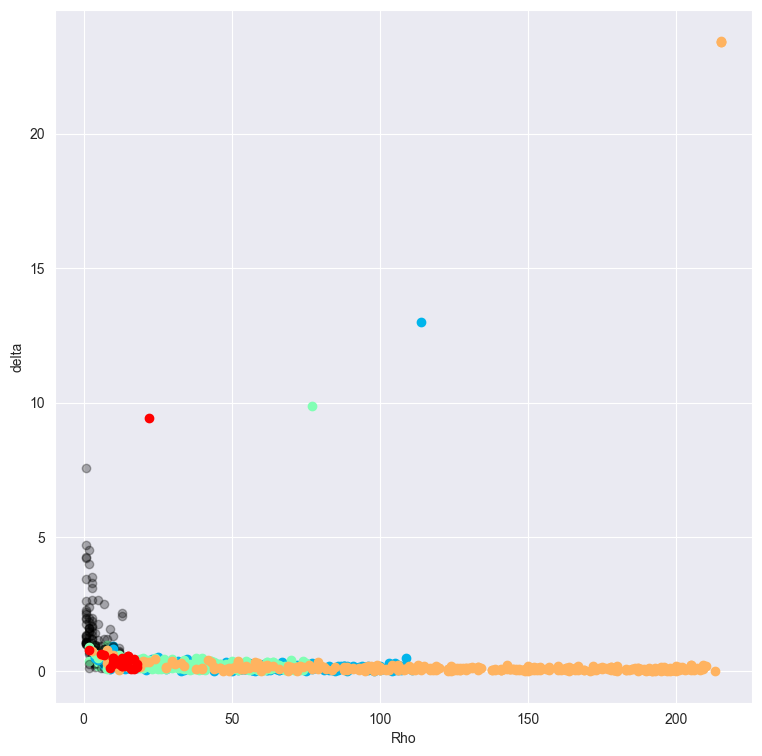

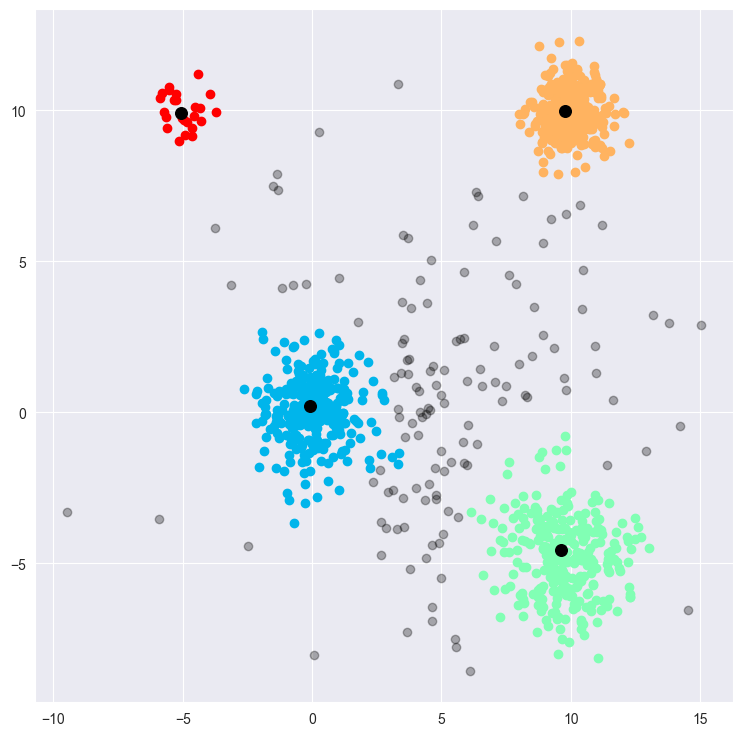

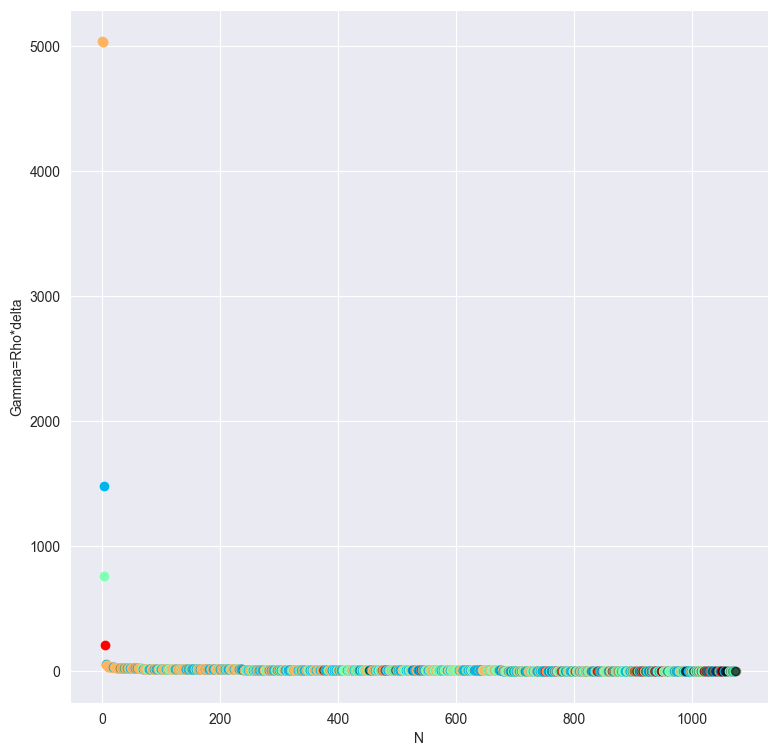

In [49]:
r=1.0
cut=1
cut_rho=20

clt, rho, delta, seeds = CFSFDP(X1, r,cut,cut_rho,True,False)   
CFSFDPprint(X1, clt, rho, delta, seeds)

#### Question 3 : For the 2nd dataset.

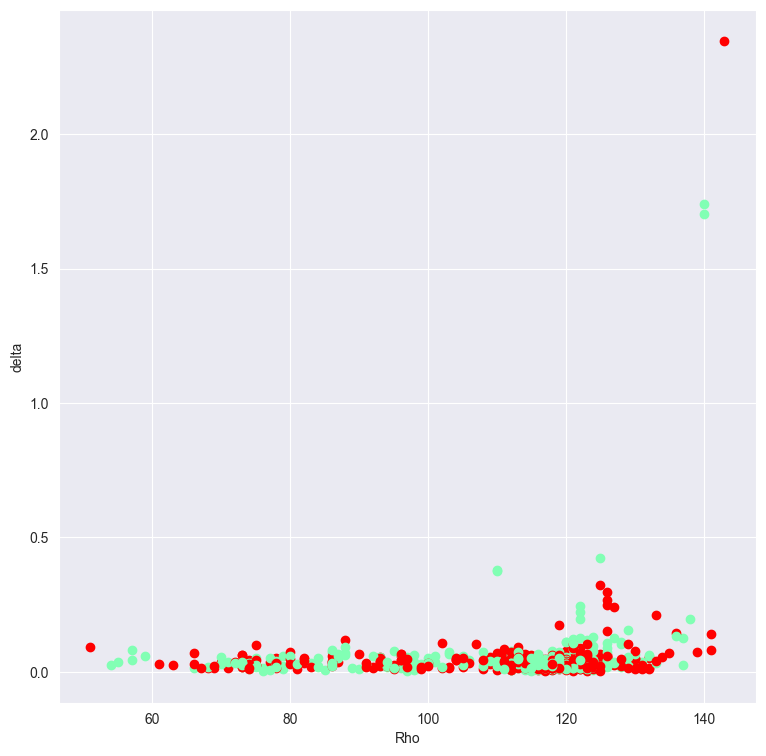

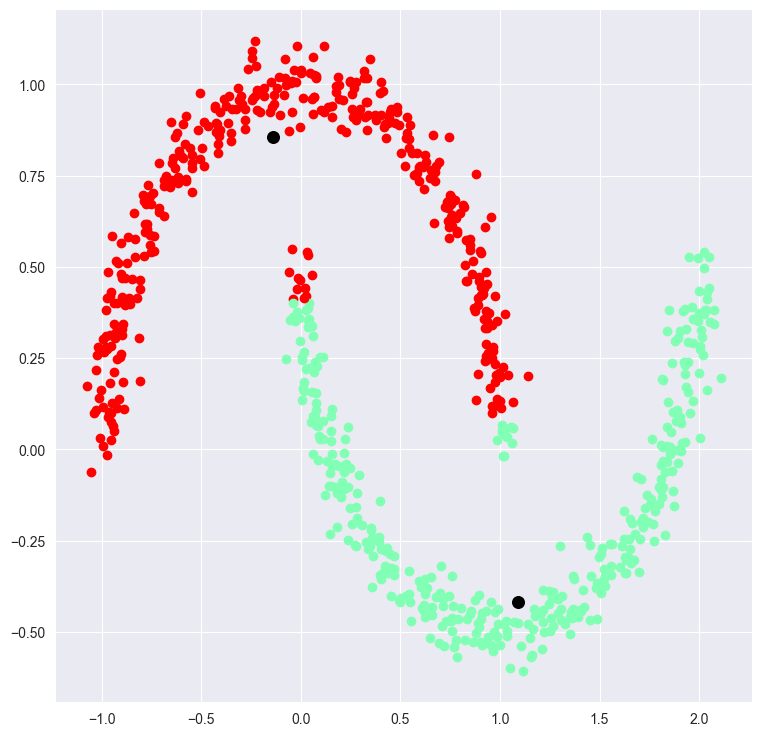

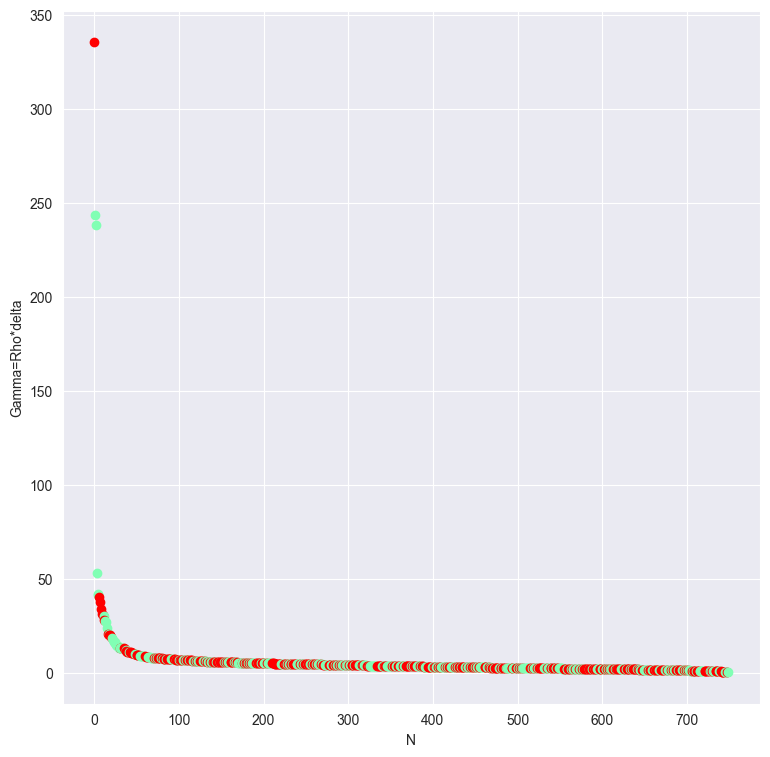

In [50]:
r=0.5
cut=1
cut_rho=20

clt, rho, delta, seeds = CFSFDP(X2, r,cut,cut_rho,False,False)   
CFSFDPprint(X2, clt, rho, delta, seeds)